## Marketing

### Ad Click

Ad clicks are a big source of revenue for many marketing businesses. PU learning means learning from positive and unlabeled data. Whether a user will click on an ad can be thought of as a problem in PU learning. I.e. if we advertise on a website and monitor activity, we will observe many users who do not click on the ad, but this doesn't mean they won't click on it at some unobserved time in the future. We think of the users who have clicked the ad during the observation period as our labeled set, and the ones who haven't as our unlabeled set, which consists of both people who never click on the ad as well as those who do at some unobserved time. 

In the language of our package we think of the labeled set as the non-censored individuals, the unlabeled set as the censored individuals, and the cured set as those individuals who never click on the ad. 

## Imports 

In [174]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sksurv.preprocessing import OneHotEncoder
from apd_crs.survival_analysis import SurvivalAnalysis
from apd_crs.datasets import load_advertising
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Using the SurvivalAnalysis Class: Get Labels

In [175]:
# Instantiate the SurvivalAnalysis class and get labels
model = SurvivalAnalysis()
cure_label = model.get_cure_label()
noncure_label = model.get_non_cure_label()
censor_label = model.get_censor_label()

## The Advertising Dataset

For illustration we use the following data set borrowed from Kaggle.com https://www.kaggle.com/farhanmd29/predicting-customer-ad-clicks/data



In [176]:
dataset = load_advertising()  # load the data


In [177]:
data, labels, times = dataset.data, dataset.target, dataset.target_times
# Load the covariates, labels (censored or not), and times


## Data Preprocessing


In [178]:
#Drop cities and Ad Topic Line, since there are too many distinct ones for only 1000 samples.

data.drop(columns=['City', 'Ad Topic Line'], inplace=True)

In [179]:
#Extract from Month, Day, Week, and Hour from the time stamp column, then drop it.

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Month'] = data['Timestamp'].dt.month
data['Day of month'] = data['Timestamp'].dt.day
data['Day of week'] = data['Timestamp'].dt.dayofweek
data['Hour'] = data['Timestamp'].dt.hour  
data.drop(columns=['Timestamp'], inplace=True)

In [180]:
# Convert object columns to categorical so we can us sksurv one-hot encoder

data['Country'] = data['Country'].astype("category")

In [181]:
# Test train split: To evaluate test performance we split the data into training and testing data;
# test_size is percentage going to test data

(
    training_data,
    test_data,
    training_labels,
    test_labels,
    
) = train_test_split(data, labels, test_size=0.33)

In [182]:
# Perform one-hot encoding

ohc = OneHotEncoder()
training_data = ohc.fit_transform(training_data)
test_data = ohc.transform(test_data)

In [183]:
#Record features post one-hot encoding

features = training_data.columns

In [184]:
# Scale covariates: Baseline Hazard estimation is parametric so scaling helps with convergence

scaler = StandardScaler()
training_data = scaler.fit_transform(training_data)
test_data = scaler.transform(test_data)

## Using the SurvivalAnalysis Class: Model Fitting

In [185]:
# Instantiate the SurvivalAnalysis class
model = SurvivalAnalysis()

In [186]:

model.pu_fit(training_data, training_labels, pu_reg_term=10., is_scar=True)

#Since our data has many columns relative to the number of rows, we use a high regularization penalty

## Overall Risk Factors

<AxesSubplot:>

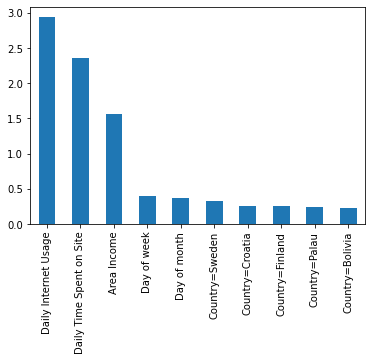

In [187]:
# By plotting the coefficients coming from the logistic regression fitted to estimate 
#cure probabilities, we can measure the overall covariate contributions. We look at the top ten:

feats = {col: model.classifier_.coef_[0][i] for (i, col) in enumerate(features)}
feats = pd.Series(feats)
top_ten_feats = feats.sort_values(ascending=False)[0:10]
top_ten_feats.plot.bar()

## Visualizing the cured/not cured distribution in the test set

In [188]:
cured_probas = \
model.predict_cure_proba(test_data, test_labels)[:,0][ model.predict_cure_proba(test_data, test_labels)[:,0]>0.5]
notcured_probas = \
model.predict_cure_proba(test_data, test_labels)[:,0][ model.predict_cure_proba(test_data, test_labels)[:,0]<=0.5]


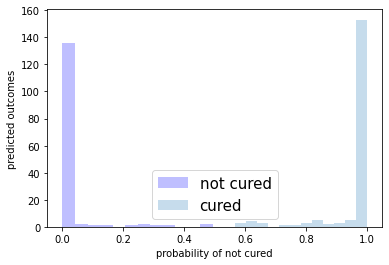

In [189]:
#We plot the predicted cured (not cured) labels on y-axis and 
#the probability of not being cured on the x-axis.


plt.xlabel('probability of not cured')
plt.ylabel('predicted outcomes')

plt.hist(notcured_probas, bins=12, label='not cured', color='blue', alpha=0.25)
plt.hist(cured_probas, bins=12, label='cured', alpha=0.25)
plt.legend(fontsize=15)

plt.show()